In [1]:
data_location = './archive'

Import imp libraries

In [2]:

import os
from collections import Counter
import spacy
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
import pandas as pd
from PIL import Image
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:

caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)

There are 40455 image to captions


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...

In [7]:
captionslist = df['caption'].tolist()
#converted entries in all captions to list

In [8]:
print(captionslist)

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .', 'A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .', 'A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails sitting in front of a rainbow painting .', 'Young girl with pigtails painting outside i

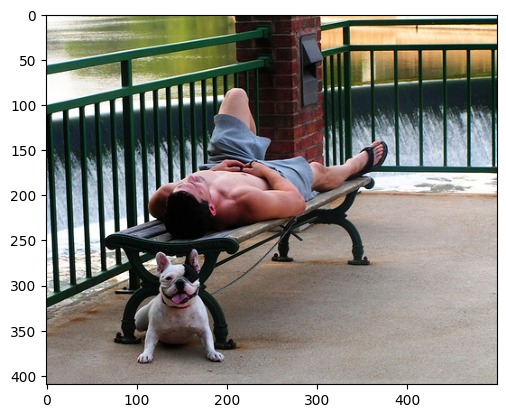

Caption: A shirtless man lies on a park bench with his dog .
Caption: man laying on bench holding leash of dog sitting on ground
Caption: A man in an orange hat starring at something .
Caption: A man wears an orange hat and glasses .
Caption: A man with gauges and glasses is wearing a Blitz hat .


'This basically plots the image and gives 5 different captions'

In [9]:
#PLotting an image at serial no 18

data_idx = 18


image_path = data_location+"/Images/"+df.iloc[data_idx,0]
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

for i in range(data_idx,data_idx+5):
    print("Caption:",df.iloc[i,1])

'''This basically plots the image and gives 5 different captions'''

Key observation : For every image there are 5 different captions

Transforming the images


In [10]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
   
])
#resized the image to 224*224 

In [11]:
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
        
    plt.pause(0.002)  

In [12]:
#prepare the dataset for model training
import matplotlib.pyplot as plt
from Flickr import FlickrDataset
dataset =  FlickrDataset(
    root_dir = data_location+"/Images",
    captions_file = data_location+"/captions.txt",
    transform=transforms
)


Loading image from: ./archive/Images/1002674143_1b742ab4b8.jpg


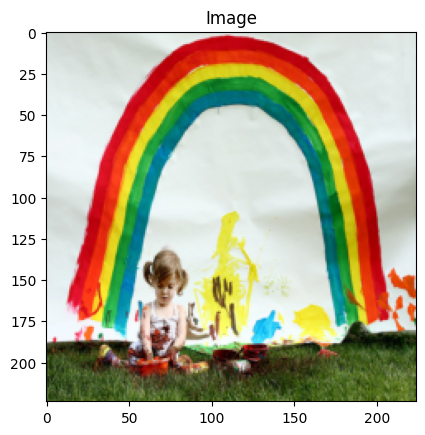

Token: tensor([   1,    4,   23,    6,  111,    5, 1447,   74,    5,   20,   12,    4,
         323,  641,    7,  131,  226,    5,    4, 1301,    8,    2])
Sentence:
['<start>', 'a', 'little', 'girl', 'covered', 'in', 'paint', 'sits', 'in', 'front', 'of', 'a', 'painted', 'rainbow', 'with', 'her', 'hands', 'in', 'a', 'bowl', '.', '<end>']


In [13]:
img, caps = dataset[0]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [14]:
from CapsCollate import CapsCollate
BATCH_SIZE = 4
NUM_WORKER = 1


pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

Loading image from: ./archive/Images/2744600462_5804577296.jpg
Loading image from: ./archive/Images/2656039837_f46b29af92.jpg
Loading image from: ./archive/Images/2739332078_13d9acce59.jpg
Loading image from: ./archive/Images/2102581664_5ea50f85c6.jpg
Loading image from: ./archive/Images/2511762757_bd0ab0a017.jpg
Loading image from: ./archive/Images/1235580648_7eebaed9bc.jpg
Loading image from: ./archive/Images/2613021139_4b0dc3d4c8.jpg
Loading image from: ./archive/Images/241345721_3f3724a7fc.jpg
Loading image from: ./archive/Images/1662261486_db967930de.jpg
Loading image from: ./archive/Images/2750867389_4b815f793a.jpg
Loading image from: ./archive/Images/2696951725_e0ae54f6da.jpg
Loading image from: ./archive/Images/2261346505_302c67951d.jpg


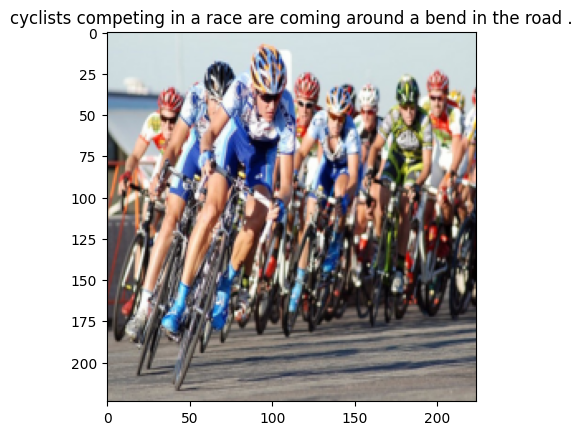

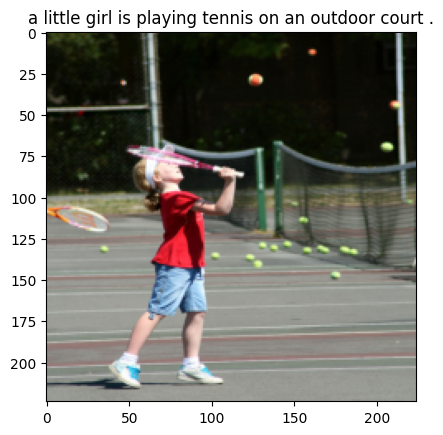

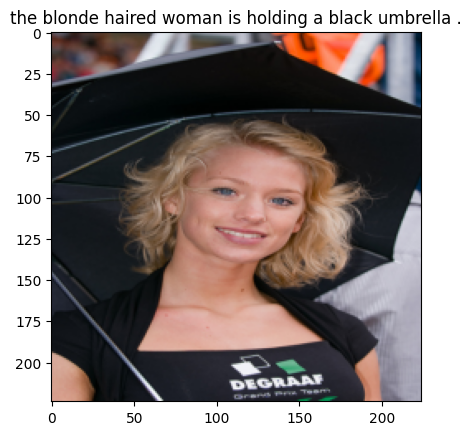

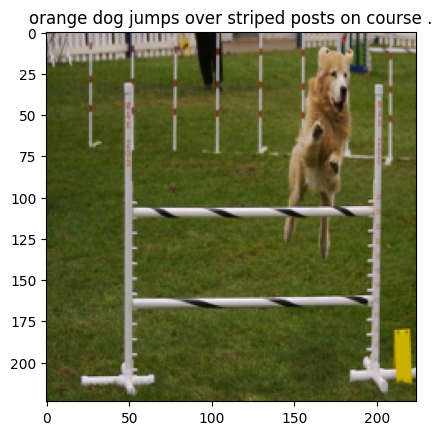

In [15]:
dataiter = iter(data_loader)
batch = next(dataiter)
images, captions = batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<end>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)
    show_image(img,caption_label)
    plt.show()

In [16]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [31]:
device = 'cpu' # can use cuda as well if it supports
#but make sure that all tensors and other hyperoarameters are in the same device.

In [32]:
print(device)

cpu


In [33]:
# iniating the model, optimisers and lossfunctions
from EncoderDecoder import EncoderDecoder
import torch.optim as optim
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

defining a function to Save the model

In [25]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

TRAIN THE MODEL


In [26]:


num_epochs = 10
print_every = 100

for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)
     
        optimizer.zero_grad()
     
        outputs,attentions = model(image, captions)
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        loss.backward()
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))


           
            model.eval()
            # with torch.no_grad():
            #     dataiter = iter(data_loader)
            #     img,_ = next(dataiter)
            #     features = model.encoder(img[0:1].to(device))
            #     caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
            #     caption = ' '.join(caps)


            model.train()

    
    save_model(model,epoch)

HELPER FUNCTIONS TO PLOT THE RESULTS

Function to generate captions

In [34]:
def get_caps_from(features_tensors):
  
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)

    return caps,alphas

Function to plot image caption

In [35]:

def plot_attention(img, result, attention_plot):
  

    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)

        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())


    plt.tight_layout()
    plt.show()

Function to load the pretrained model

In [41]:
def load_model(model_path):
    
    vocab_size = len(dataset.vocab) 
    
    
    model = EncoderDecoder(
        embed_size=300,
        vocab_size=vocab_size,
        attention_dim=256,
        encoder_dim=2048,
        decoder_dim=512
    )

   
    state_dict = torch.load(model_path)
    
    model_state_dict = state_dict['state_dict']
    
   
    model.load_state_dict(model_state_dict)
    
  
    model.eval()
    
    return model

Load the pretrained model

In [42]:
model_path = 'attention_model_state.pth'

model = load_model(model_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RESULTS!!!!!

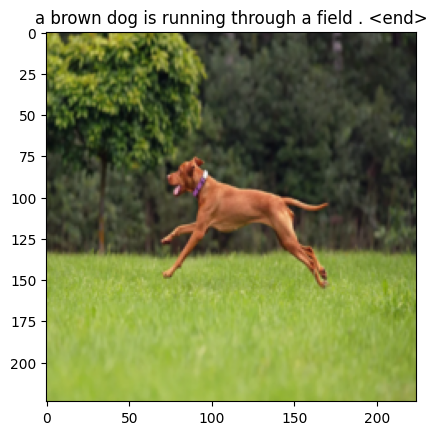

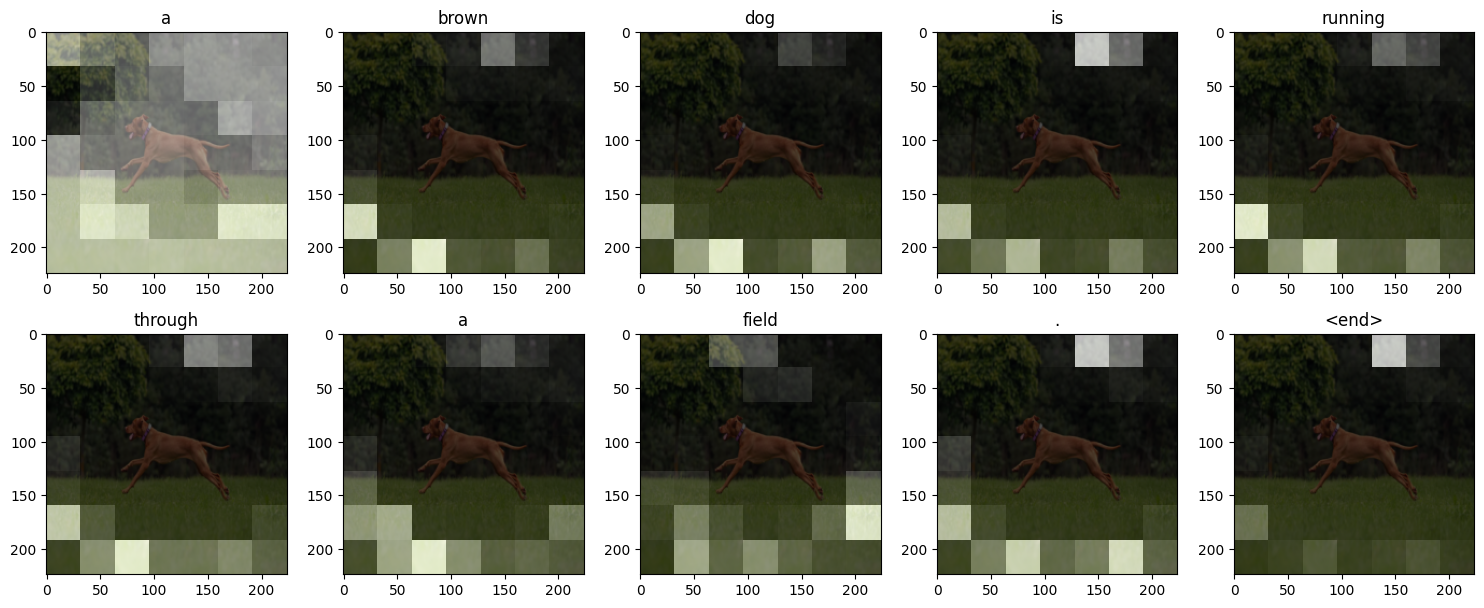

In [43]:
'''Load any pic of your choice and insert the realtive path in img_path.. karna plzzz '''
import torchvision.transforms as transforms

img_path = './test.jpeg'
image = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
  
    transforms.ToTensor()
])
image_tensor = transform(image).unsqueeze(0) 


caps, alphas = get_caps_from(image_tensor)


plot_attention(image_tensor.squeeze(), caps, alphas)


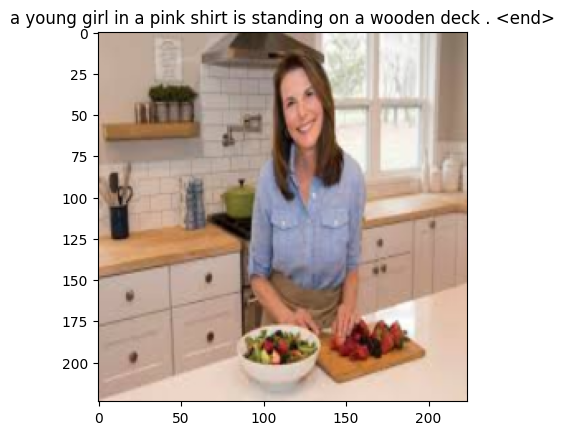

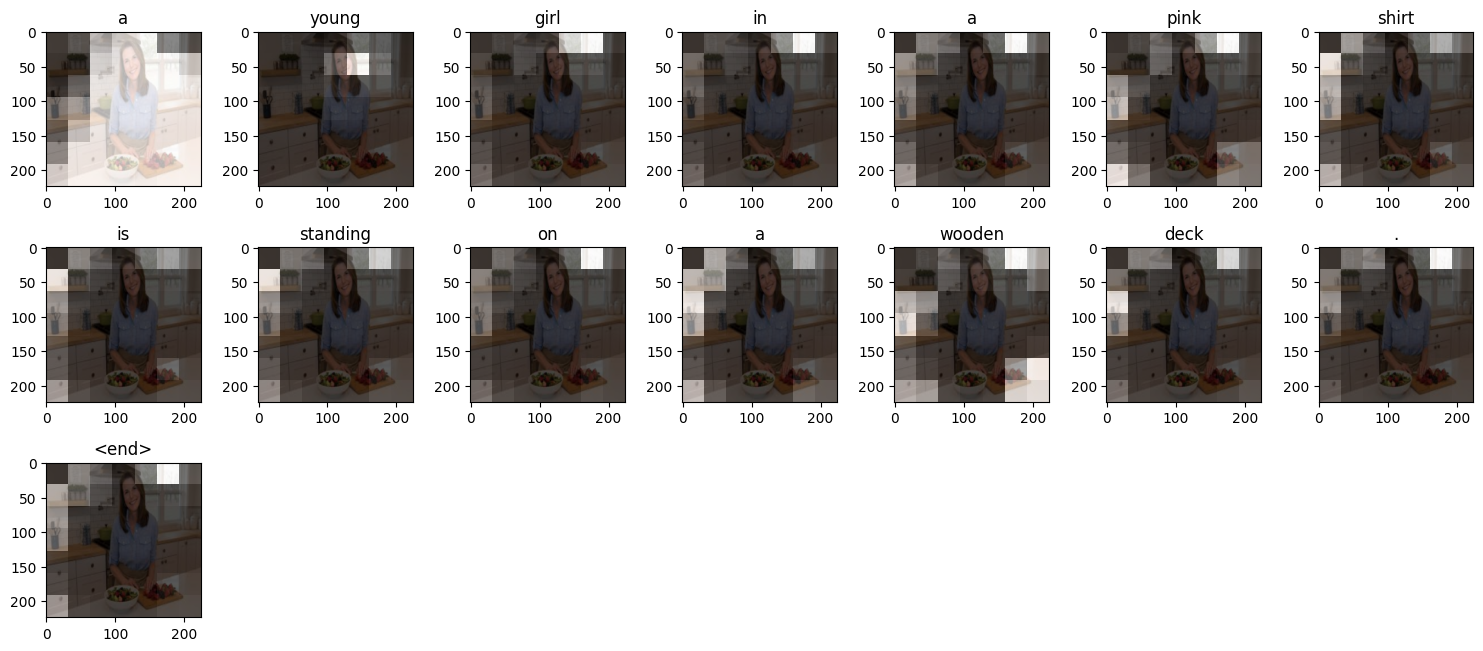

In [44]:
img_path = './images.jpeg'
image = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
  
    transforms.ToTensor()
])
image_tensor = transform(image).unsqueeze(0) 


caps, alphas = get_caps_from(image_tensor)


plot_attention(image_tensor.squeeze(), caps, alphas)

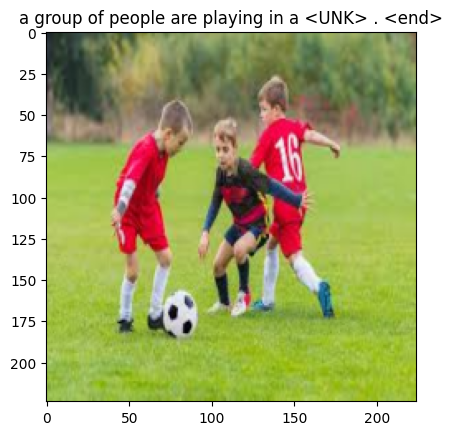

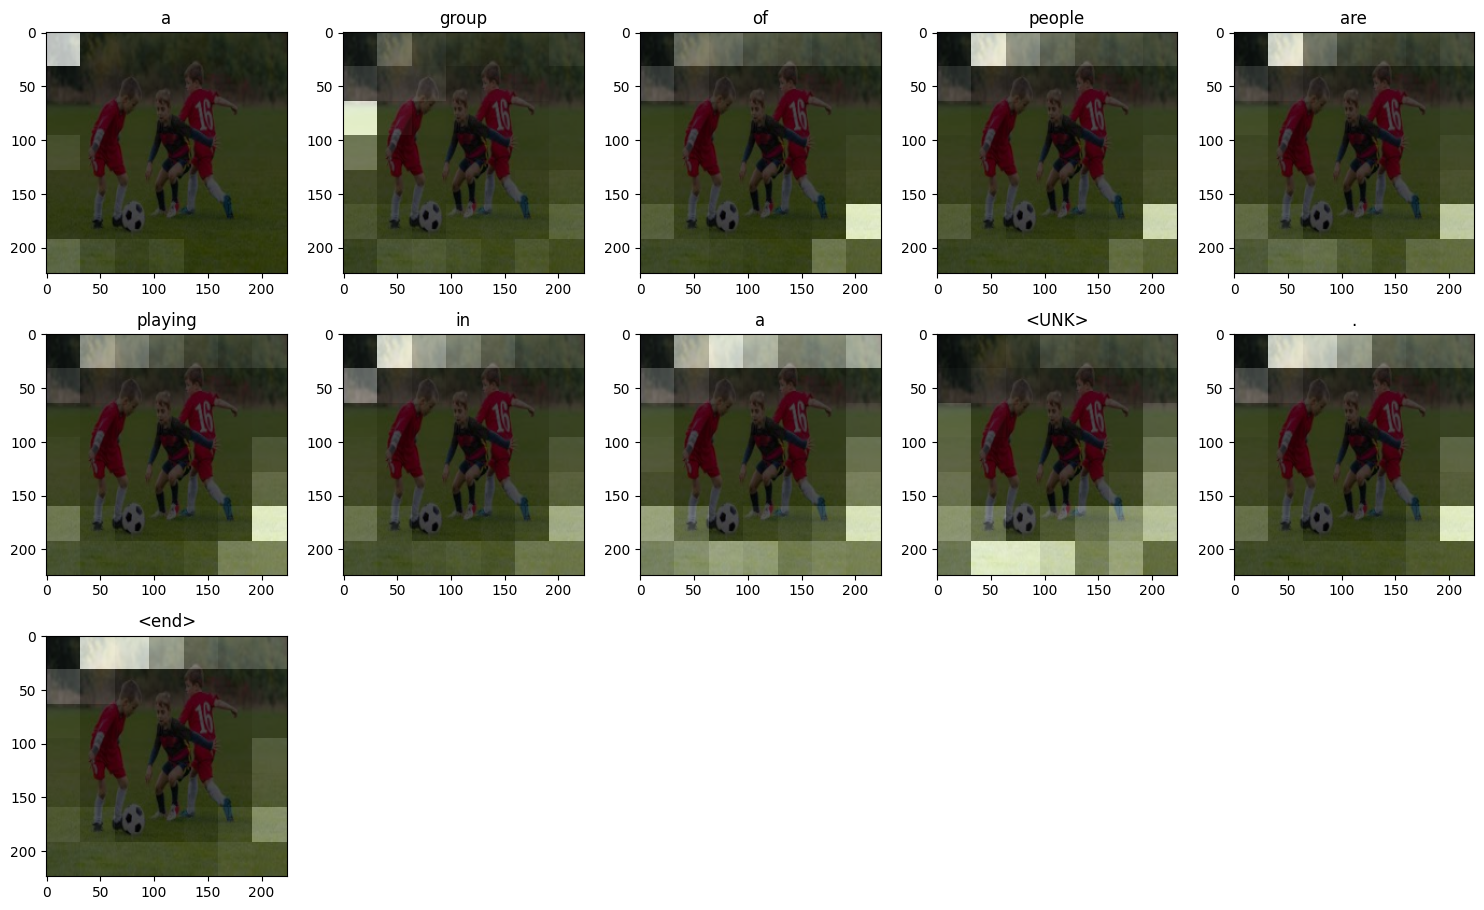

In [45]:
img_path = './download.jpeg'
image = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
  
    transforms.ToTensor()
])
image_tensor = transform(image).unsqueeze(0) 


caps, alphas = get_caps_from(image_tensor)


plot_attention(image_tensor.squeeze(), caps, alphas)

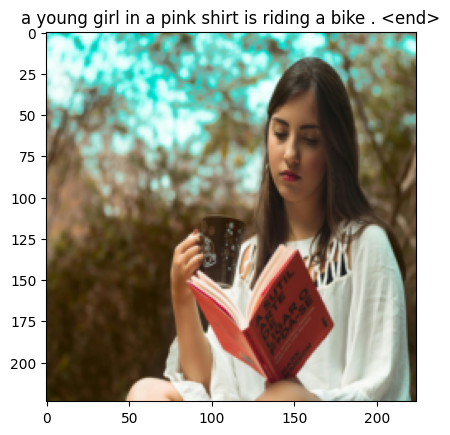

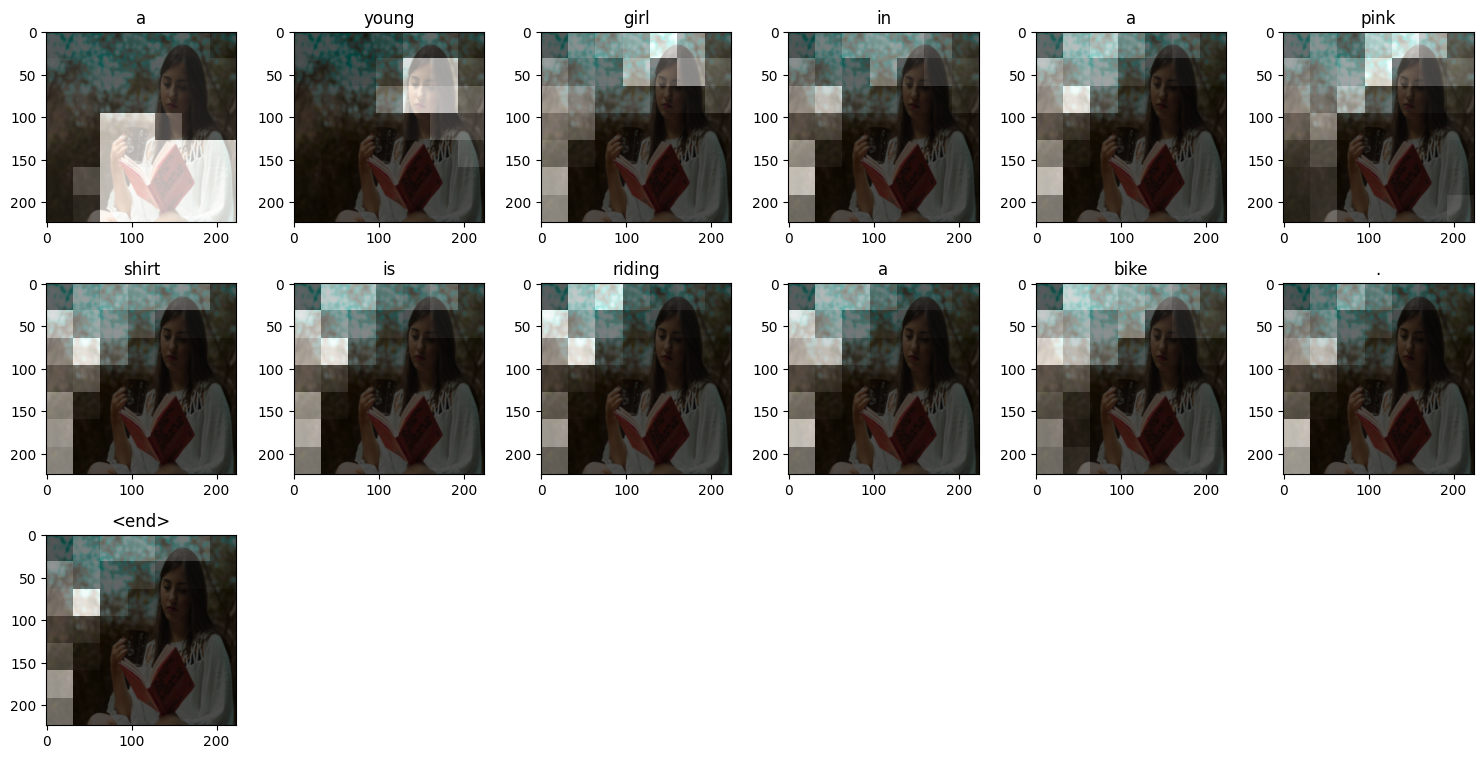

In [46]:
img_path = './test3.jpeg'
image = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
  
    transforms.ToTensor()
])
image_tensor = transform(image).unsqueeze(0) 


caps, alphas = get_caps_from(image_tensor)


plot_attention(image_tensor.squeeze(), caps, alphas)